

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных Samsung Human Activity Recognition. Скачайте данные отсюда. Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в веб-форме.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.family']='DejaVu Sans'

In [4]:
from sklearn import metrics

In [5]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE=17

In [6]:
X_train=np.loadtxt('samsung_train.txt')
y_train=np.loadtxt('samsung_train_labels.txt')

In [7]:
X_test=np.loadtxt('samsung_test.txt')
y_test=np.loadtxt('samsung_test_labels.txt')

In [8]:
X_train.shape , y_train.shape

((7352, 561), (7352,))

In [9]:
X_test.shape , y_test.shape

((2947, 561), (2947,))



**Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините X_train с X_test, а y_train – с y_test.**


In [10]:
X=np.c_[X_train,y_train]

In [11]:
X

array([[ 0.28858451, -0.02029417, -0.13290514, ...,  0.17994061,
        -0.05862692,  5.        ],
       [ 0.27841883, -0.01641057, -0.12352019, ...,  0.18028889,
        -0.05431672,  5.        ],
       [ 0.27965306, -0.01946716, -0.11346169, ...,  0.18063731,
        -0.04911782,  5.        ],
       ...,
       [ 0.27338737, -0.01701062, -0.04502183, ...,  0.24914484,
         0.04081119,  2.        ],
       [ 0.28965416, -0.01884304, -0.15828059, ...,  0.24643223,
         0.02533948,  2.        ],
       [ 0.35150347, -0.01242312, -0.20386717, ...,  0.24680852,
         0.03669484,  2.        ]])

In [12]:
X.shape

(7352, 562)

In [13]:
xx=np.vstack([X_train,X_test])

In [14]:
xx.shape

(10299, 561)

In [15]:
y=np.concatenate([y_train,y_test])

In [16]:
y

array([5., 5., 5., ..., 2., 2., 2.])

In [17]:
y.shape

(10299,)

In [18]:
xxx=np.concatenate([X_train,X_test])

In [19]:
xxx.shape

(10299, 561)

# Испытав множество способов и функций пришли к выводу, что поможет обычная конкатенация.

In [20]:
X=np.concatenate([X_train,X_test])

In [21]:
y=np.concatenate([y_train,y_test])

Определим число уникальных значений меток класса

In [22]:
np.unique(y)

array([1., 2., 3., 4., 5., 6.])

In [23]:
n_classes = np.unique(y).size

In [24]:
n_classes

6



Эти метки соответствуют:

    1 - ходьбе
    2 - подъему вверх по лестнице
    3 - спуску по лестнице
    4 - сидению
    5 - стоянию
    6 - лежанию

уж простите, если звучание этих существительных кажется корявым :)

### Отмасштабируйте выборку с помощью StandardScaler с параметрами по умолчанию.


In [25]:
scaler= StandardScaler()

In [26]:
X_scaled=scaler.fit_transform(X)

In [27]:
X_scaled

array([[ 2.10533854e-01, -6.87026385e-02, -4.52194533e-01, ...,
        -6.74432366e-01,  3.82007658e-01, -1.61505480e-02],
       [ 6.02084832e-02,  3.59023537e-02, -2.75221885e-01, ...,
        -6.81359801e-01,  3.83147865e-01, -1.20627169e-04],
       [ 7.84597052e-02, -4.64269585e-02, -8.55480582e-02, ...,
        -6.89470939e-01,  3.84288531e-01,  1.92144041e-02],
       ...,
       [ 1.11821625e+00,  1.28805864e+00, -1.29414692e-01, ...,
        -3.10750224e-01,  6.91509049e-01,  8.75719123e-01],
       [-5.43492722e-01,  9.75327452e-01,  2.34319837e-01, ...,
        -3.19283719e-01,  6.59762215e-01,  8.99444350e-01],
       [-1.78515253e+00, -1.86663622e-02, -5.29759691e-01, ...,
        -3.19991245e-01,  6.56994458e-01,  9.01454465e-01]])



## Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).


In [28]:
pca_new = PCA(0.90)
pca_new.fit(X_scaled)
print(pca_new.explained_variance_ratio_)

[0.50738221 0.06239186 0.02692564 0.02452871 0.01888936 0.01631395
 0.01414533 0.01216211 0.00985248 0.00949228 0.00858304 0.0080998
 0.00765863 0.00676668 0.00630242 0.00615718 0.00595335 0.00577195
 0.00563431 0.0054083  0.00518828 0.00502742 0.00473229 0.00463818
 0.00446848 0.00439868 0.00416863 0.00400809 0.00389072 0.00381339
 0.0036687  0.00364357 0.00349225 0.00346736 0.00335539 0.00329411
 0.00323824 0.00300508 0.00294254 0.00290452 0.00275765 0.00269864
 0.00264196 0.0025803  0.00255031 0.00247776 0.00245537 0.0023829
 0.00235902 0.00232044 0.0022836  0.00219182 0.00212631 0.00209145
 0.0020348  0.00201167 0.00198111 0.00194391 0.00192509 0.00189539
 0.00186403 0.00182923 0.00180956 0.00176364 0.00174188]


In [29]:
X_pca=pca_new.fit(X_scaled)

# Вопрос 1:
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [30]:
X_pca

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [31]:
pca_new.explained_variance_ratio_.shape

(65,)

65 - главных компонент будут описывать 90% дисперсий исходных данных



# Вопрос 2:
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

In [32]:
X_comp=pca_new.explained_variance_ratio_

In [33]:
X_comp[:1]*100

array([50.73822104])

50%

# Визуализируйте данные в проекции на первые две главные компоненты.

In [34]:
X_reduced = pca_new.fit_transform(X_scaled)

In [35]:
X_reduced

array([[-16.38097982,   1.99508307,   3.41569023, ...,   0.34256962,
         -0.24397444,  -1.94678658],
       [-15.58217328,   1.18259368,  -0.32120675, ...,   0.13742091,
         -0.16081322,  -0.61432028],
       [-15.42398918,   2.24316643,  -1.23778356, ...,  -1.47098019,
         -1.24311139,   0.24672176],
       ...,
       [ 11.84685312,  -3.43356502,   2.18801926, ...,  -0.94467044,
         -0.34497972,  -2.09465647],
       [  8.20668637,  -4.38648876,   1.31871955, ...,   0.11723446,
         -1.32786056,   0.08742446],
       [  9.31117251,  -3.98616133,   1.93301747, ...,   0.12988206,
         -1.86396408,  -0.18253505]])

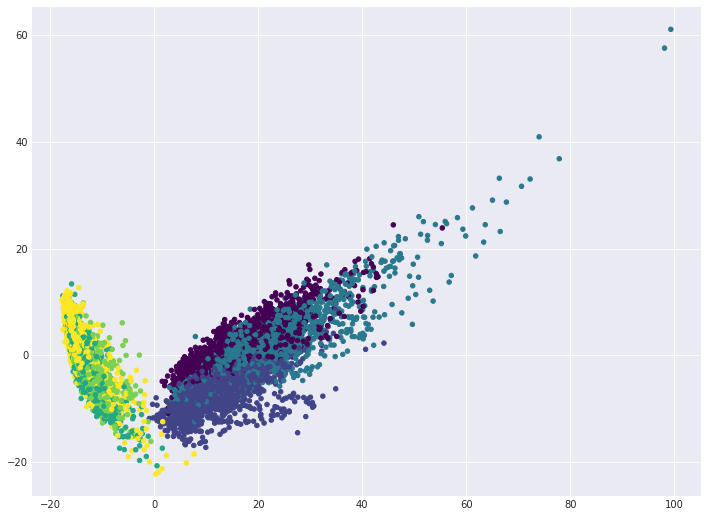

In [36]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y, s=20, cmap='viridis');

Мы видим что данные разделились на 6 кластеров, как и должно быть



# Сделайте кластеризацию данных методом KMeans, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

    n_clusters = n_classes (число уникальных меток целевого класса)
    n_init = 100
    random_state = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.


In [37]:
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE);

In [38]:
kmeans.fit(X_reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=17, tol=0.0001, verbose=0)



# Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

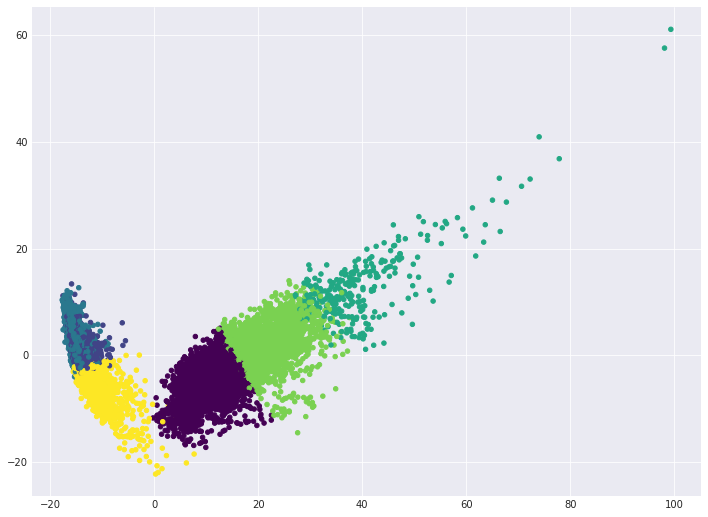

In [39]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=kmeans.labels_, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм KMeans путает.

In [40]:


tab = pd.crosstab(y, kmeans.labels_, margins=True)

In [41]:
tab

col_0,0,1,2,3,4,5,All
row_0,,,,,,,
1.0,903,0,0,78,741,0,1722
2.0,1241,0,0,5,296,2,1544
3.0,320,0,0,196,890,0,1406
4.0,1,1235,91,0,0,450,1777
5.0,0,1344,0,0,0,562,1906
6.0,5,52,1558,0,0,329,1944
All,2470,2631,1649,279,1927,1343,10299


In [42]:
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']

In [43]:
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,78,741,0,1722
подъем вверх по лестнице,1241,0,0,5,296,2,1544
спуск по лестнице,320,0,0,196,890,0,1406
сидение,1,1235,91,0,0,450,1777
стояние,0,1344,0,0,0,562,1906
лежание,5,52,1558,0,0,329,1944
все,2470,2631,1649,279,1927,1343,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов, распределение кластеров такое:

    кластер 1 – 900
    кластер 3 – 500
    кластер 6 – 6,

то такая доля будет 900 / 1406 ≈

0.64.

Вопрос 4:
Какой вид активности отделился от остальных лучше всего в терминах простой метрики, описанной выше?

Ответ:

    ходьба
    стояние
    спуск по лестнице
    перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только n_clusters.


# Агломеративная класстеризация

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [44]:
n_classes

6

In [45]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_reduced)

ag.fit(X_reduced)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=6,
            pooling_func='deprecated')

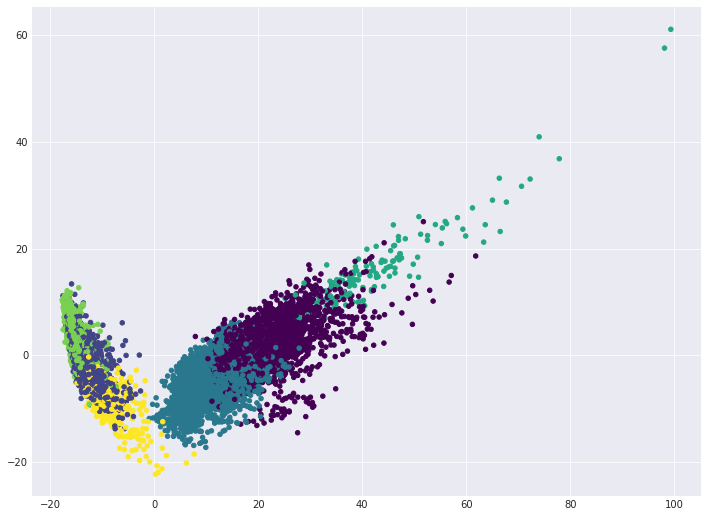

In [46]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=ag.labels_, s=20,  cmap='viridis');

In [47]:
ag.fit_predict(X_reduced)

array([1, 1, 1, ..., 2, 2, 2])

In [50]:
from sklearn.metrics import adjusted_rand_score

In [51]:
adjusted_rand_score(y, ag.fit_predict(X_reduced))

0.49362763373004886

Если бы вектор правильных ответов полностью совпадал с нашим предсказанным вектором кластеров, то ARI = 1, но у нас значение близкое к 0.5, что свидетельствует о половине совпадений меток

Так определяется Adjusted Rand Index: $$\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}.$$

Эта мера симметрична, не зависит от значений и перестановок меток. Таким образом, данный индекс является мерой расстояния между различными разбиениями выборки. $\text{ARI}$ принимает значения в диапазоне $[-1, 1]$. Отрицательные значения соответствуют "независимым" разбиениям на кластеры, значения, близкие к нулю, - случайным разбиениям, и положительные значения говорят о том, что два разбиения схожи (совпадают при $\text{ARI} = 1$).

In [52]:
from sklearn.metrics import adjusted_rand_score

In [53]:
y.shape, X.shape

((10299,), (10299, 561))

In [54]:
adjusted_rand_score(y,kmeans.predict(X_reduced))

0.4198070012602345

Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры



Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.

# SVC (метод опорных векторов)

Для классификации используйте метод опорных векторов – класс sklearn.svm.LinearSVC. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова – тут.

Настройте для LinearSVC гиперпараметр C с помощью GridSearchCV.

    Обучите новый StandardScaler на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
    В GridSearchCV укажите cv=3.



In [55]:
scaler2=StandardScaler()

In [56]:
X_train_scaled=scaler2.fit_transform(X_train)
X_test_scaled=scaler2.fit(X_test)

In [57]:
svc=LinearSVC(random_state=RANDOM_STATE)
svc_params={'C' : [0.001, 0.01, 0.1, 1, 10]}

In [59]:
%%time
best_svc=GridSearchCV(svc, svc_params);

CPU times: user 107 µs, sys: 32 µs, total: 139 µs
Wall time: 144 µs


In [60]:
%%time
best_svc.fit(X_train_scaled,y_train)

CPU times: user 55.6 s, sys: 2.99 s, total: 58.6 s
Wall time: 54.3 s


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [61]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382480957562568)

In [71]:
X_train_scaled.shape

(7352, 561)

In [75]:
X_test_scaled=scaler2.fit_transform(X_test)

In [76]:
X_test_scaled.shape

(2947, 561)

In [77]:
y_predicted=best_svc.predict(X_test_scaled)

In [81]:
y_predicted[:10]

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [82]:
from sklearn.metrics import accuracy_score

In [83]:
accuracy_score(y_test, y_predicted)

0.9636918900576857

In [80]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab



,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,479,11,4,2,0,0,496
подъем вверх по лестнице,4,465,1,1,0,0,471
спуск по лестнице,1,2,416,1,0,0,420
сидение,0,4,0,433,52,2,491
стояние,0,0,0,16,516,0,532
лежание,0,0,0,0,6,531,537
все,484,482,421,453,574,533,2947


## PCA

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

    Используйте выборки X_train_scaled и X_test_scaled
    Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
    Настройте гиперпараметр C на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.


In [84]:
pca=PCA(0.90)

In [103]:
pca_clf=pca.fit(X_train_scaled);

In [104]:
pca_clf

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [105]:
pca_clf_test = pca_clf.transform(X_test_scaled)

In [107]:
pca_clf_test


array([[-10.94511942,  -1.86116925,   2.22811041, ...,   0.44028398,
         -0.09441371,  -1.15662541],
       [-14.11388787,  -1.07789259,  -0.39670433, ...,  -1.33970659,
          1.30057841,  -0.34042183],
       [-15.32424431,   2.36521609,  -2.25329687, ...,  -0.37584992,
          0.54946263,   0.56238668],
       ...,
       [ 13.04527751,  -2.90806716,   3.20774534, ...,   4.47013025,
          2.34572471,  -0.02205161],
       [  9.08003829,  -3.97068504,   1.92692084, ...,   0.1179185 ,
         -0.46799649,   2.08710576],
       [ 10.36151617,  -3.45369912,   2.29164702, ...,   1.82944726,
          2.26428009,   1.9461746 ]])

In [110]:
plt.scatter(pca_clf_test[:,0],pca_clf_test[:,1], , s=20, cmap='viridis');

AttributeError: 'PCA' object has no attribute 'labels_'